In [1]:
import os
import cv2
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [134]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
# folder dataset
happy_folder = "dataset/happy/"
angry_folder = "dataset/angry/"
sad_folder = "dataset/sad/"

limit = 250

In [5]:
# load images
images_happy = [cv2.imread(file) for file in glob.glob(happy_folder+"*.jpg")][:limit]
images_angry = [cv2.imread(file) for file in glob.glob(angry_folder+"*.jpg")][:limit]
images_sad = [cv2.imread(file) for file in glob.glob(sad_folder+"*.jpg")][:limit]

In [6]:
# images labeling
labels_happy = [0] * len(images_happy)
labels_angry = [1] * len(images_angry)
labels_sad = [2] * len(images_sad)

In [7]:
# checking data
happy_count = len(images_happy)
happy_count

250

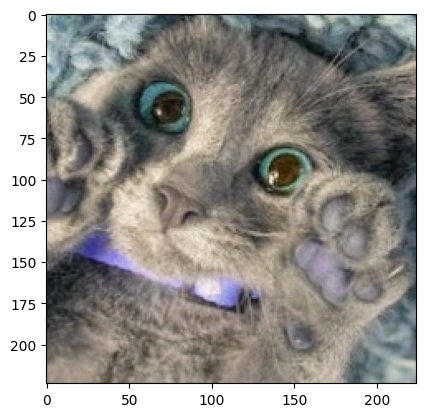

In [8]:
img = np.asarray(images_happy[66])
imgplot = plt.imshow(img)

In [9]:
# resize images to 112x112

common_size = (112,112)
images_happy = [cv2.resize(image, common_size) for image in images_happy]
images_angry = [cv2.resize(image, common_size) for image in images_angry]
images_sad = [cv2.resize(image, common_size) for image in images_sad]

In [10]:
# Concatenate images and labels
X = np.concatenate((images_happy, images_angry, images_sad), axis = 0)
y = np.concatenate((labels_happy, labels_angry, labels_sad), axis = 0)

In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [12]:
X_train.shape

(600, 112, 112, 3)

In [13]:
y_train.shape

(600,)

In [14]:
def initialize_model():

    model = models.Sequential()

    model.add(layers.Conv2D(64, (3,3), activation="relu", input_shape=(112, 112, 3)))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(64, (3,3), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(128, (3,3), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(64, (2,2), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(32, activation='relu'))
    
    model.add(layers.Dense(16, activation='relu'))

    model.add(layers.Dense(3, activation='softmax'))
    
    ### Model compilation
    model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])
       
    
    return model

In [15]:
# Training the model

model = initialize_model()

In [16]:
es = EarlyStopping(patience = 10, restore_best_weights= True)

history = model.fit(X_train, y_train,
                    epochs = 25,
                    batch_size = 64,
                    validation_split = 0.2,
                    callbacks = [es],
                    verbose = 1)

Epoch 1/25
8/8 [==============================] - 3s 357ms/step - loss: 6.8988 - accuracy: 0.3521 - val_loss: 1.4361 - val_accuracy: 0.3417
Epoch 2/25
8/8 [==============================] - 3s 351ms/step - loss: 1.2275 - accuracy: 0.3938 - val_loss: 1.2358 - val_accuracy: 0.4250
Epoch 3/25
8/8 [==============================] - 3s 331ms/step - loss: 1.0521 - accuracy: 0.4917 - val_loss: 1.1376 - val_accuracy: 0.3917
Epoch 4/25
8/8 [==============================] - 3s 419ms/step - loss: 0.9962 - accuracy: 0.4792 - val_loss: 1.1316 - val_accuracy: 0.3667
Epoch 5/25
8/8 [==============================] - 3s 372ms/step - loss: 0.9523 - accuracy: 0.5437 - val_loss: 1.1874 - val_accuracy: 0.3250
Epoch 6/25
8/8 [==============================] - 3s 342ms/step - loss: 0.9180 - accuracy: 0.5604 - val_loss: 1.2416 - val_accuracy: 0.3417
Epoch 7/25
8/8 [==============================] - 3s 347ms/step - loss: 0.8900 - accuracy: 0.5917 - val_loss: 1.0874 - val_accuracy: 0.4083
Epoch 8/25
8/8 [====

In [17]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    
    # ----Loss----
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['Train', 'Validation'], loc= 'best')
    ax[0].grid(axis='x', linewidth=0.5)
    ax[0].grid(axis='y', linewidth=0.5)
    
    # ----Accuracy----
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(['Train', 'Validation'], loc= 'best')
    ax[1].grid(axis='x', linewidth=0.5)
    ax[1].grid(axis='y', linewidth=0.5)
    
    if title:
        fig.suptitle(title)

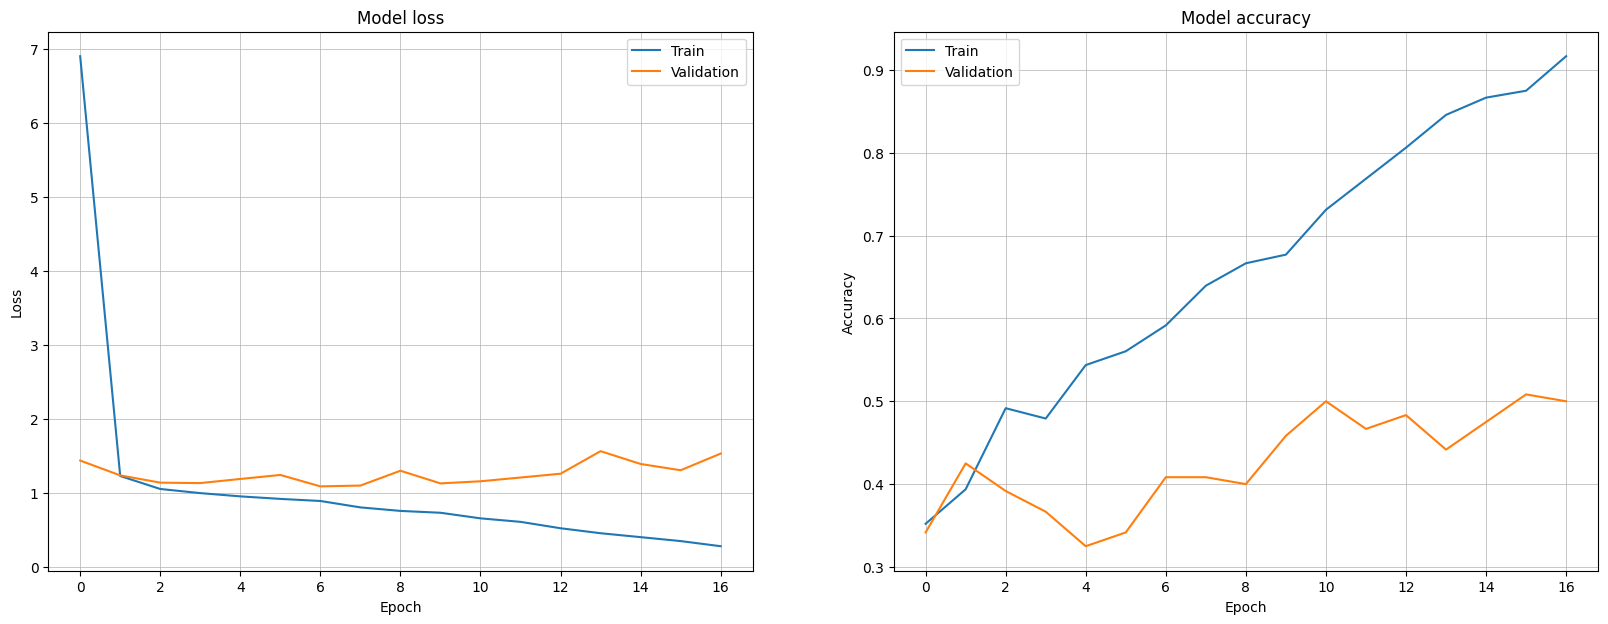

In [18]:
plot_loss_accuracy(history, title=None)

In [19]:
evaluation = model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 49ms/step - loss: 1.0622 - accuracy: 0.4733


In [20]:
print(f'Model accuracy is {round(evaluation[1]*100,2)} %')

Model accuracy is 47.33 %


# VCG16 Model

In [21]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input as preprocess_input_vgg16

In [120]:
def initialize_vgg16_model():
    # Load the pre-trained VGG16 model without the top (fully connected) layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(112, 112, 3))

    # Freeze the layers of the pre-trained VGG16 model
    for layer in base_model.layers:
        layer.trainable = False

    # Create a Sequential model
    model = Sequential()

    # Add the pre-trained VGG16 model as the first layer
    model.add(base_model)


    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    # Model compilation
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [121]:
model_vgg16 = initialize_vgg16_model()

In [122]:
es = EarlyStopping(patience = 5, restore_best_weights= True)

history = model_vgg16.fit(X_train, y_train,
                    epochs = 25,
                    batch_size = 32,
                    validation_split = 0.2,
                    callbacks = [es],
                    verbose = 1)

Epoch 1/25
15/15 [==============================] - 15s 973ms/step - loss: 40.8320 - accuracy: 0.5312 - val_loss: 9.5830 - val_accuracy: 0.6833
Epoch 2/25
15/15 [==============================] - 15s 1s/step - loss: 9.0713 - accuracy: 0.7729 - val_loss: 7.7071 - val_accuracy: 0.7917
Epoch 3/25
15/15 [==============================] - 16s 1s/step - loss: 3.5748 - accuracy: 0.8854 - val_loss: 6.2247 - val_accuracy: 0.8083
Epoch 4/25
15/15 [==============================] - 16s 1s/step - loss: 1.4915 - accuracy: 0.9125 - val_loss: 4.2874 - val_accuracy: 0.8583
Epoch 5/25
15/15 [==============================] - 17s 1s/step - loss: 1.2673 - accuracy: 0.9354 - val_loss: 4.1829 - val_accuracy: 0.8500
Epoch 6/25
15/15 [==============================] - 17s 1s/step - loss: 0.4966 - accuracy: 0.9625 - val_loss: 4.7535 - val_accuracy: 0.8167
Epoch 7/25
15/15 [==============================] - 17s 1s/step - loss: 0.7848 - accuracy: 0.9604 - val_loss: 5.1518 - val_accuracy: 0.8417
Epoch 8/25
15/15

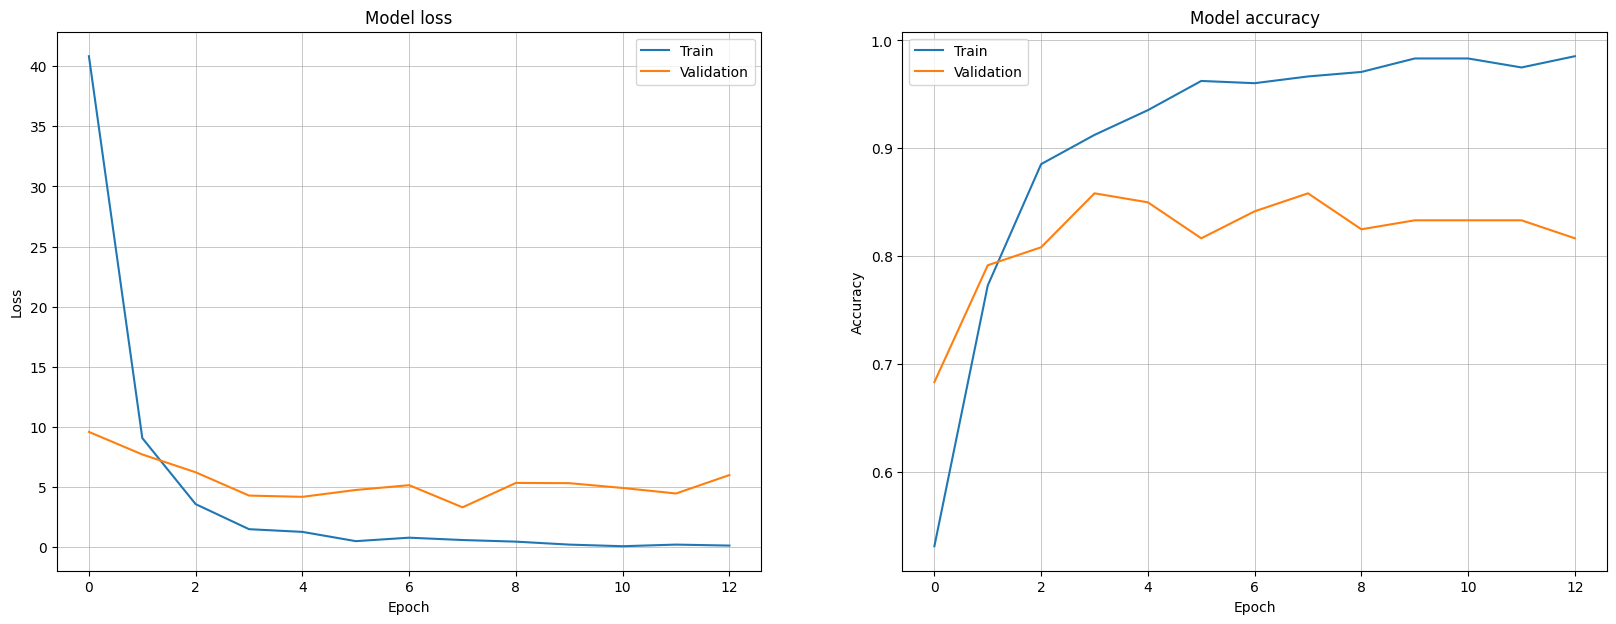

In [124]:
plot_loss_accuracy(history, title=None)

In [125]:
evaluation = model_vgg16.evaluate(X_test, y_test)

5/5 [==============================] - 4s 710ms/step - loss: 3.7564 - accuracy: 0.8600


In [126]:
print(f'Model accuracy is {round(evaluation[1]*100,2)} %')

Model accuracy is 86.0 %


# VCG19 Model

In [28]:
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input as preprocess_input_vgg19

In [29]:
def initialize_vgg19_model():
    # Load the pre-trained VGG19 model without the top (fully connected) layers
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(112, 112, 3))

    # Freeze the layers of the pre-trained VGG19 model
    for layer in base_model.layers:
        layer.trainable = False

    # Create a Sequential model
    model = Sequential()

    # Add the pre-trained VGG19 model as the first layer
    model.add(base_model)


    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))

    # Model compilation
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [30]:
model_vgg19 = initialize_vgg19_model()

In [31]:
es = EarlyStopping(patience = 5, restore_best_weights= True)

history = model_vgg19.fit(X_train, y_train,
                    epochs = 25,
                    batch_size = 32,
                    validation_split = 0.2,
                    callbacks = [es],
                    verbose = 1)

Epoch 1/25
15/15 [==============================] - 22s 1s/step - loss: 34.8835 - accuracy: 0.5167 - val_loss: 11.8167 - val_accuracy: 0.7500
Epoch 2/25
15/15 [==============================] - 22s 1s/step - loss: 6.6528 - accuracy: 0.8042 - val_loss: 6.9560 - val_accuracy: 0.7667
Epoch 3/25
15/15 [==============================] - 22s 1s/step - loss: 1.2675 - accuracy: 0.9292 - val_loss: 3.0210 - val_accuracy: 0.8583
Epoch 4/25
15/15 [==============================] - 22s 1s/step - loss: 0.2254 - accuracy: 0.9750 - val_loss: 2.4275 - val_accuracy: 0.8917
Epoch 5/25
15/15 [==============================] - 22s 1s/step - loss: 0.1475 - accuracy: 0.9854 - val_loss: 2.7570 - val_accuracy: 0.8333
Epoch 6/25
15/15 [==============================] - 23s 2s/step - loss: 0.3461 - accuracy: 0.9729 - val_loss: 2.5484 - val_accuracy: 0.8750
Epoch 7/25
15/15 [==============================] - 23s 2s/step - loss: 0.2074 - accuracy: 0.9896 - val_loss: 3.0367 - val_accuracy: 0.8750
Epoch 8/25
15/15 [

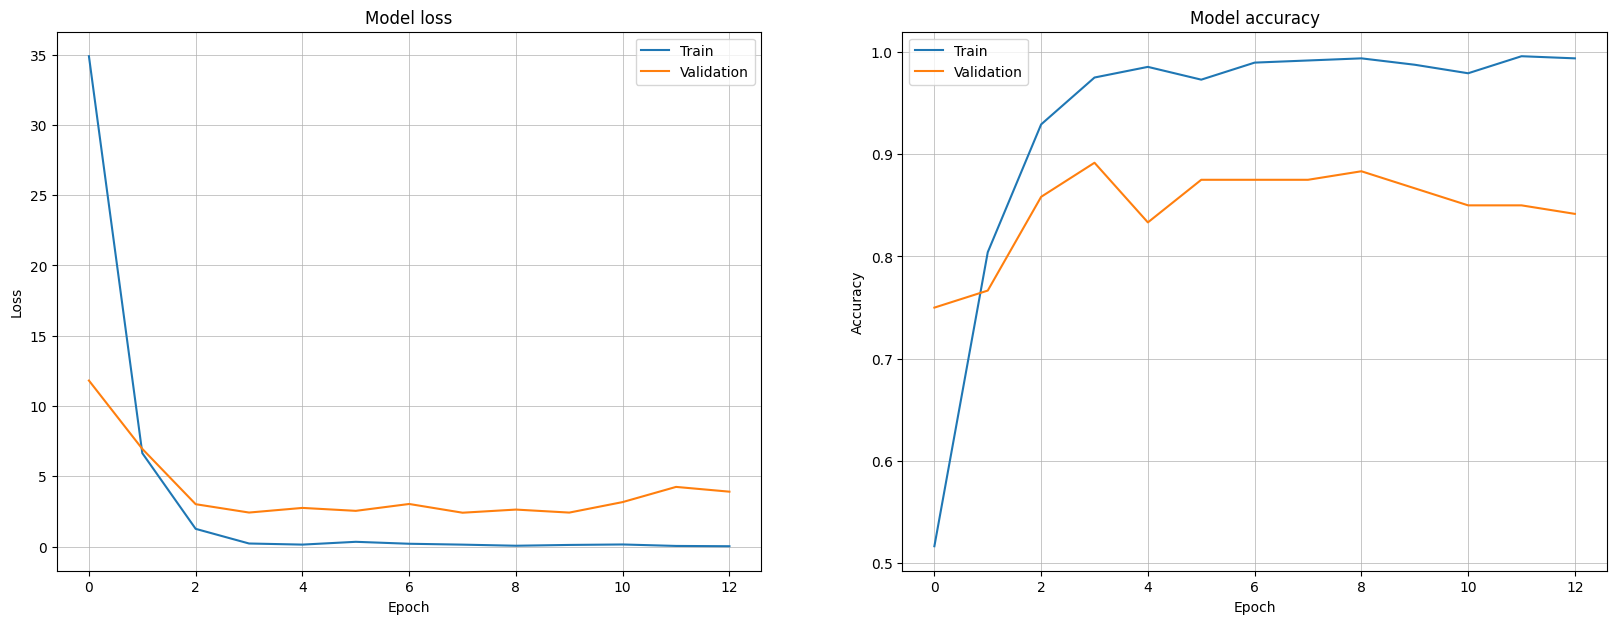

In [32]:
plot_loss_accuracy(history, title=None)

In [33]:
evaluation = model_vgg19.evaluate(X_test, y_test)

5/5 [==============================] - 6s 1s/step - loss: 3.3995 - accuracy: 0.7933


In [34]:
print(f'Model accuracy is {round(evaluation[1]*100,2)} %')

Model accuracy is 79.33 %


# EfficientNetB3

In [94]:
from tensorflow.keras.applications.efficientnet import preprocess_input
from keras.applications import EfficientNetB2

In [95]:
def initialize_effnetB2_model():
    # Load the pre-trained EfficientNetB2 model without the top (fully connected) layers
    base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(112, 112, 3))

    # Freeze the layers of the pre-trained EfficientNetB2 model
    for layer in base_model.layers:
        layer.trainable = False

    # Create a Sequential model
    model = Sequential()


    # Add the pre-trained EfficientNetB2 model as the first layer
    model.add(base_model)


    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))

    # Model compilation
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [96]:
model_effnet = initialize_effnetB2_model()

31790344/31790344 [==============================] - 3s 0us/step


In [97]:
es = EarlyStopping(patience = 5, restore_best_weights= True)

history = model_effnet.fit(X_train, y_train,
                    epochs = 25,
                    batch_size = 32,
                    validation_split = 0.2,
                    callbacks = [es],
                    verbose = 1)

Epoch 1/25
15/15 [==============================] - 7s 252ms/step - loss: 3.0256 - accuracy: 0.5771 - val_loss: 1.0881 - val_accuracy: 0.7500
Epoch 2/25
15/15 [==============================] - 4s 280ms/step - loss: 0.6334 - accuracy: 0.8458 - val_loss: 0.6775 - val_accuracy: 0.8500
Epoch 3/25
15/15 [==============================] - 3s 222ms/step - loss: 0.2221 - accuracy: 0.9271 - val_loss: 0.3809 - val_accuracy: 0.8667
Epoch 4/25
15/15 [==============================] - 3s 220ms/step - loss: 0.1169 - accuracy: 0.9583 - val_loss: 0.3140 - val_accuracy: 0.8833
Epoch 5/25
15/15 [==============================] - 3s 206ms/step - loss: 0.0404 - accuracy: 0.9854 - val_loss: 0.2896 - val_accuracy: 0.9083
Epoch 6/25
15/15 [==============================] - 3s 202ms/step - loss: 0.0266 - accuracy: 0.9875 - val_loss: 0.3539 - val_accuracy: 0.8667
Epoch 7/25
15/15 [==============================] - 3s 201ms/step - loss: 0.0360 - accuracy: 0.9854 - val_loss: 0.2669 - val_accuracy: 0.9250
Epoch 

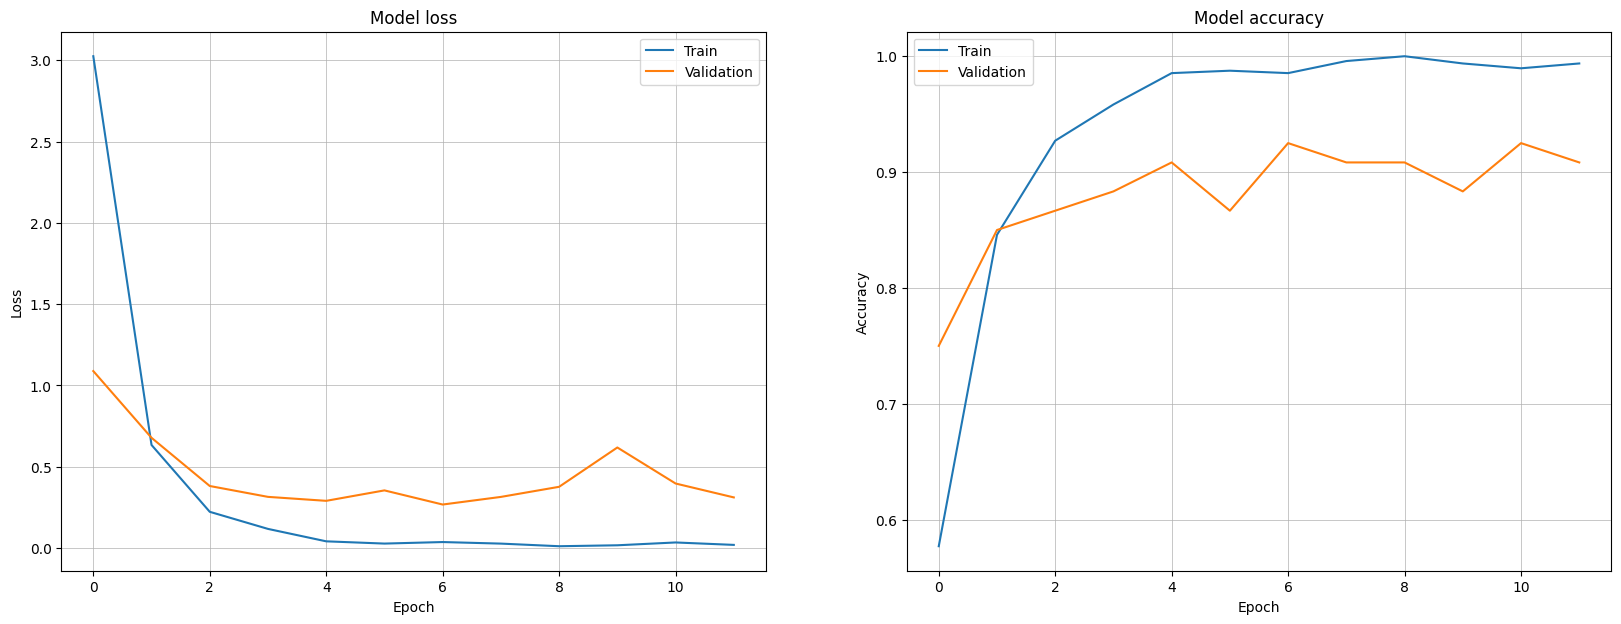

In [98]:
plot_loss_accuracy(history, title=None)

In [99]:
evaluation = model_effnet.evaluate(X_test, y_test)

5/5 [==============================] - 1s 145ms/step - loss: 0.4629 - accuracy: 0.8600


In [100]:
print(f'Model accuracy is {round(evaluation[1]*100,2)} %')

Model accuracy is 86.0 %


In [127]:
# Save model
model_vgg16.save("pets_expression_vgg16_86%.h5")

In [129]:
prediction = model.predict(X_test)

5/5 [==============================] - 1s 48ms/step


In [131]:
def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(112, 112))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

In [132]:
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model("pets_expression_vgg16_86%.h5")

In [258]:
# Replace 'path_to_your_image' with the path to your animal image
img_array = load_and_preprocess_image('dataset/cat_test/kucinggif.jpg')

In [259]:
# Make a prediction
prediction = model.predict(img_array)

1/1 [==============================] - 0s 62ms/step


In [260]:
# Decode the prediction
emotion = np.argmax(prediction)
emotions = ['Happy', 'Angry', 'Sad']
predicted_emotion = emotions[emotion]

print("Predicted Emotion:", predicted_emotion)

Predicted Emotion: Happy
